In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.constants import G
from astropy import units as u
from scipy.integrate import quad
import symlib
import os
from glob import glob
import seaborn as sns
from scipy.stats import spearmanr
from scipy.optimize import curve_fit   
from scipy.interpolate import interp1d

suite_names = ["SymphonyLMC", "SymphonyMilkyWay", "SymphonyGroup", "SymphonyLCluster", "SymphonyCluster"]
sim_colors = {
        "SymphonyLMC": sns.color_palette("colorblind")[4],
        "SymphonyMilkyWay": sns.color_palette("colorblind")[0],
        "SymphonyGroup": sns.color_palette("colorblind")[2],
        "SymphonyLCluster": sns.color_palette("colorblind")[1],
        "SymphonyCluster": sns.color_palette("colorblind")[3],
    }
sim_names = {
        "SymphonyLMC": "LMC",
        "SymphonyMilkyWay": "Milky~Way",
        "SymphonyGroup": "Group",
        "SymphonyLCluster": "L-Cluster",
        "SymphonyCluster": "Cluster",
    }

base_dir='/Users/fengbocheng/Projects/Symphony-PPSD/output/z_0'

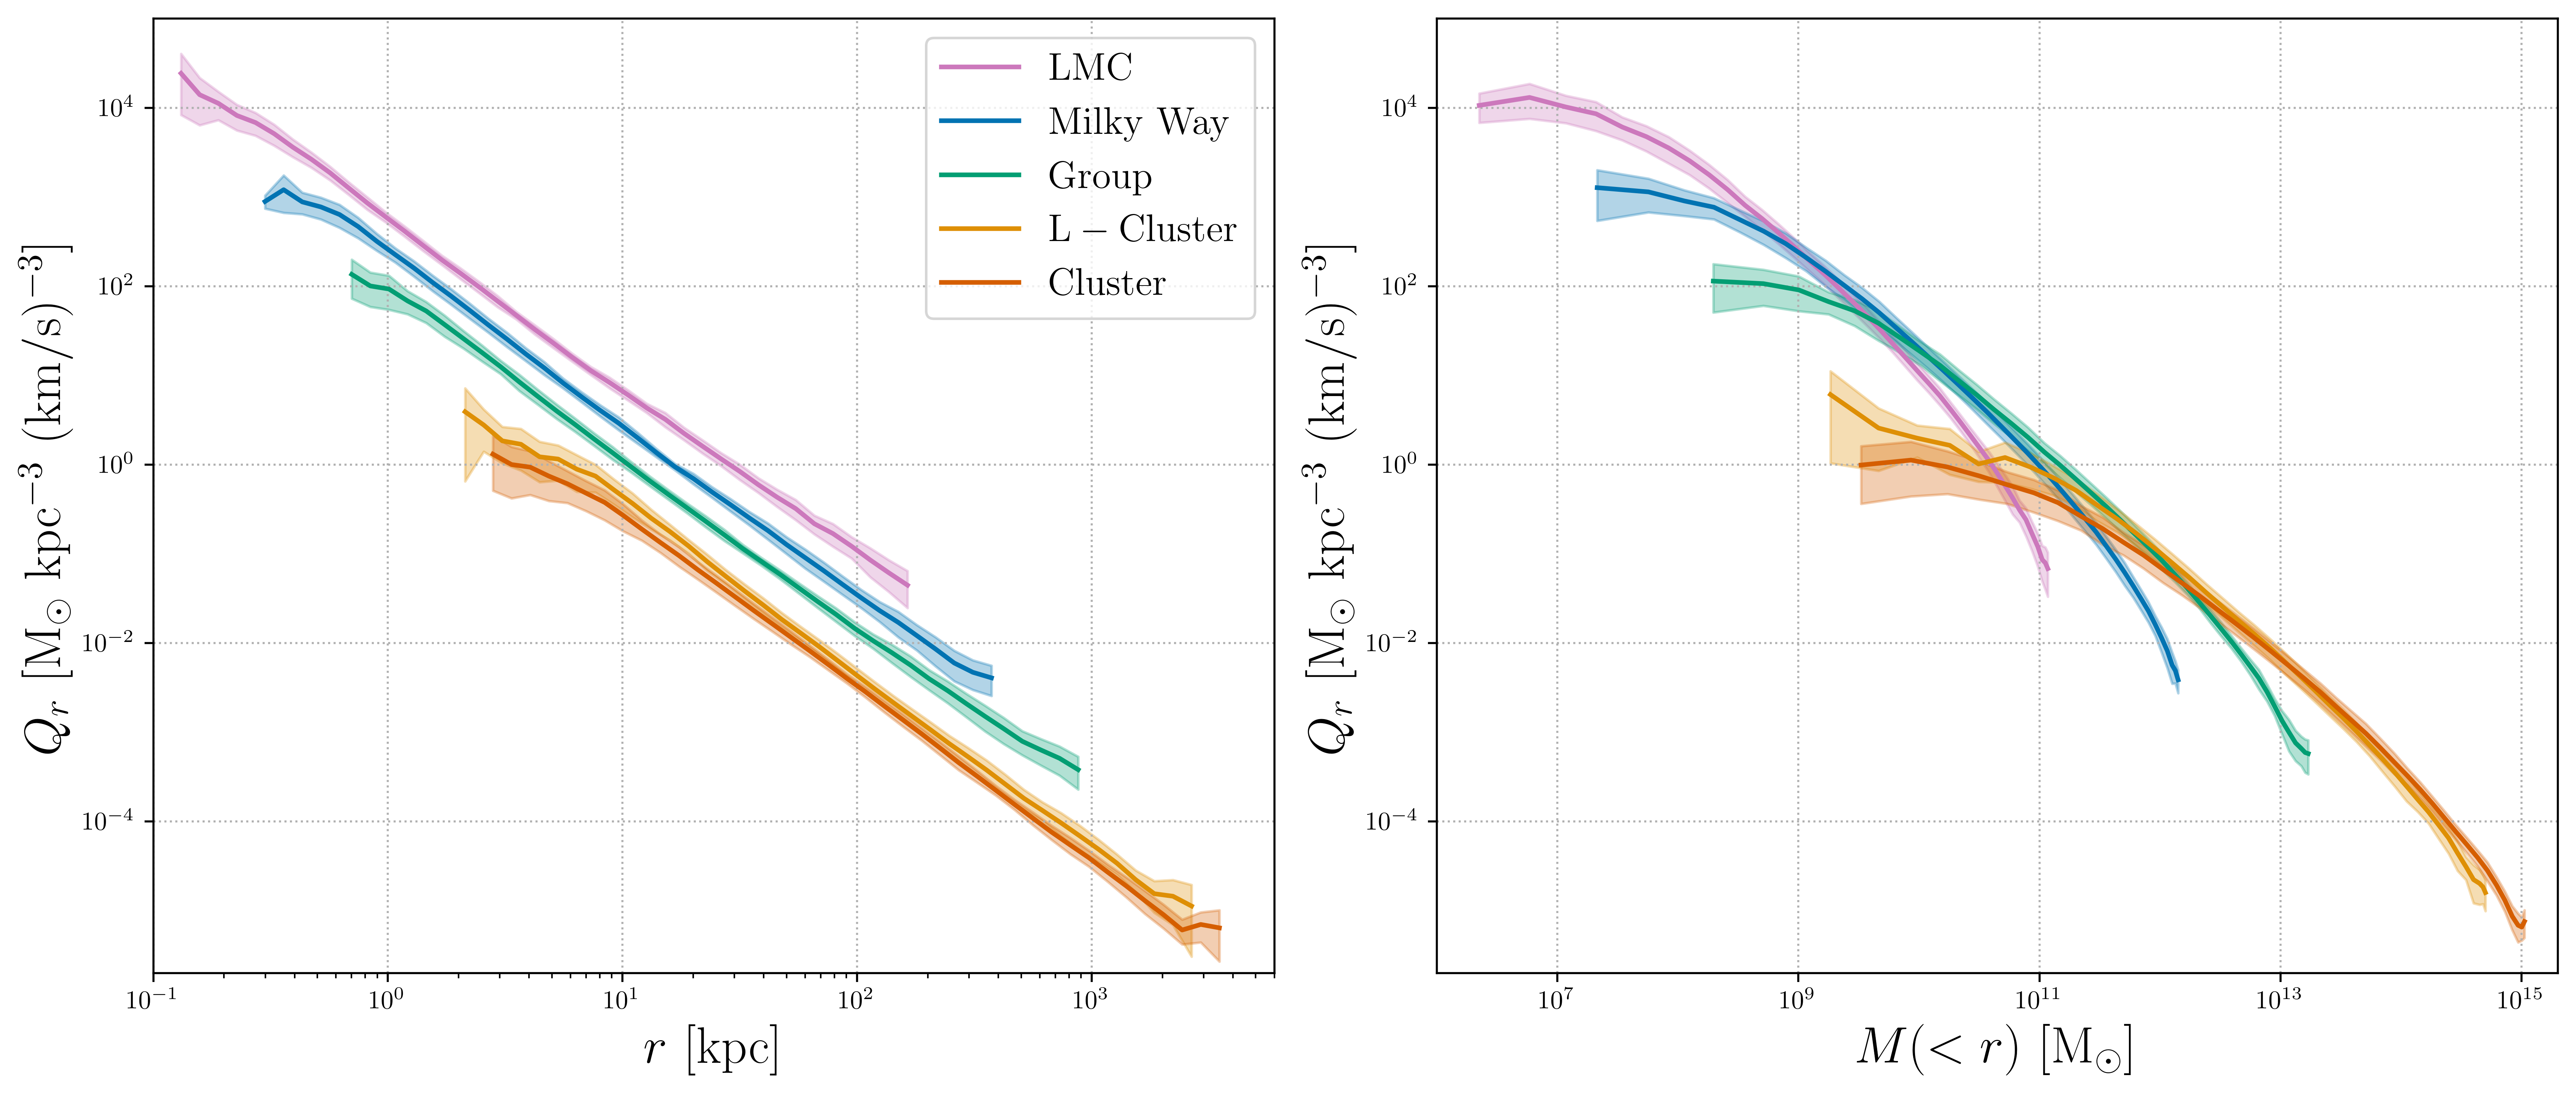

In [ ]:
def plot_dimensional_ppsd(base_dir):
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=500)
    plt.rcParams['text.usetex'] = True

    for suite in suite_names:
        input_dir = os.path.join(base_dir, "data", suite, "ppsd_profiles")

        files = sorted([f for f in os.listdir(input_dir) if f.endswith(".csv")])
        # Load halo-specific virial quantities
        rvir_df = pd.read_csv(os.path.join(base_dir, "data", suite, "virial_radius.csv"),dtype={"halo_id": str})
        vvir_df = pd.read_csv(os.path.join(base_dir, "data", suite, "virial_velocity.csv"),dtype={"halo_id": str})
        mvir_df = pd.read_csv(os.path.join(base_dir, "data", suite, "halo_mass.csv"),dtype={"halo_id": str})

        # Compute background density
        params = symlib.simulation_parameters(suite)
        H0_si = params["H0"] * u.km / u.s / u.Mpc
        G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
        rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
        rho_m = params["Om0"] * rho_crit

        Qr_list, r_list, m_list= [], [], []

        for f in files:
            halo_id = f.split("_")[1]
            profile = pd.read_csv(os.path.join(input_dir, f))
            # Scaled variables
            r_scaled = profile["r_scaled"].values
            m_scaled = profile["m_scaled"].values
            Qr_dimensionless = profile['Q_r'].values

            # Halo virial values
            Rvir = float(rvir_df.loc[rvir_df["halo_id"] == halo_id, "rvir"].values[0])
            Vvir = float(vvir_df.loc[vvir_df["halo_id"] == halo_id, "vvir"].values[0])
            Mvir = float(mvir_df.loc[mvir_df["halo_id"] == halo_id, "mvir"].values[0])
            
            # Dimensional quantities
            r = r_scaled * Rvir
            m = m_scaled * Mvir
            Qr_dimensional = Qr_dimensionless * rho_m / Vvir**3

            # Save for plotting
            Qr_list.append(Qr_dimensional)
            r_list.append(r)
            m_list.append(m)

        # Stack arrays for interpolation and mean
        r_common = r_list[0]
        m_common = np.nanmean(np.vstack(m_list), axis=0)
        Qr_r = np.array([np.interp(r_common, r, q, left=np.nan, right=np.nan) for r, q in zip(r_list, Qr_list)])
        Qr_m = np.array([np.interp(m_common, m, q, left=np.nan, right=np.nan) for m, q in zip(m_list, Qr_list)])

        from astropy.stats import sigma_clip
        Qr_r_clipped = sigma_clip(Qr_r, sigma=3, axis=0)
        Qr_m_clipped = sigma_clip(Qr_m, sigma=3, axis=0)
        mean_Qr_r = np.nanmean(Qr_r_clipped, axis=0)
        std_Qr_r  = np.nanstd(Qr_r_clipped, axis=0)
        mean_Qr_m = np.nanmean(Qr_m_clipped, axis=0)
        std_Qr_m = np.nanstd(Qr_m_clipped, axis=0)

        # Plot Q_r vs r
        axes[0].plot(r_common, mean_Qr_r, color=sim_colors[suite], lw=1.8, label = rf"$\mathrm{{{sim_names[suite]}}}$")
        axes[0].fill_between(r_common, mean_Qr_r - std_Qr_r, mean_Qr_r + std_Qr_r,
                             color=sim_colors[suite], alpha=0.3)

        # Plot Q_r vs M
        axes[1].plot(m_common, mean_Qr_m, color=sim_colors[suite], lw=1.8, label=sim_names[suite])
        axes[1].fill_between(m_common, mean_Qr_m - std_Qr_m, mean_Qr_m + std_Qr_m,
                             color=sim_colors[suite], alpha=0.3)

    # Final plot styling
    axes[0].set_xlabel(r"$r\ [{\rm kpc}]$", fontsize=20)
    axes[0].set_ylabel(r"$Q_r\ [{\rm M_\odot\ kpc^{-3}\ (km/s)^{-3}}]$", fontsize=20)
    axes[0].set_xlim(1e-1, 6e3)
    axes[0].set_ylim(2e-6, 1e5)
    axes[0].set_xscale("log")
    axes[0].set_yscale("log")
    axes[0].grid(True, which="major", linestyle=":")
    axes[0].legend(fontsize=15, loc="best", frameon=True)

    axes[1].set_xlabel(r"$M(<r)\ [{\rm M_\odot}]$", fontsize=20)
    axes[1].set_ylabel(r"$Q_r\ [{\rm M_\odot\ kpc^{-3}\ (km/s)^{-3}}]$", fontsize=20)
    axes[1].set_xlim(1e6, 2e15)
    axes[1].set_ylim(2e-6, 1e5)
    axes[1].set_xscale("log")
    axes[1].set_yscale("log")
    axes[1].grid(True, which="major", linestyle=":")

    fig.tight_layout()
    save_path = os.path.join(base_dir, 'figure', "dimensional_ppsd_profiles.pdf")
    for ax in axes:
        ax.tick_params(which='minor', labelsize=13)
    plt.savefig(save_path)
    plt.show()
    plt.close(fig)

plot_dimensional_ppsd(base_dir)

[Skip] halo_id 072 missing in one of the meta tables


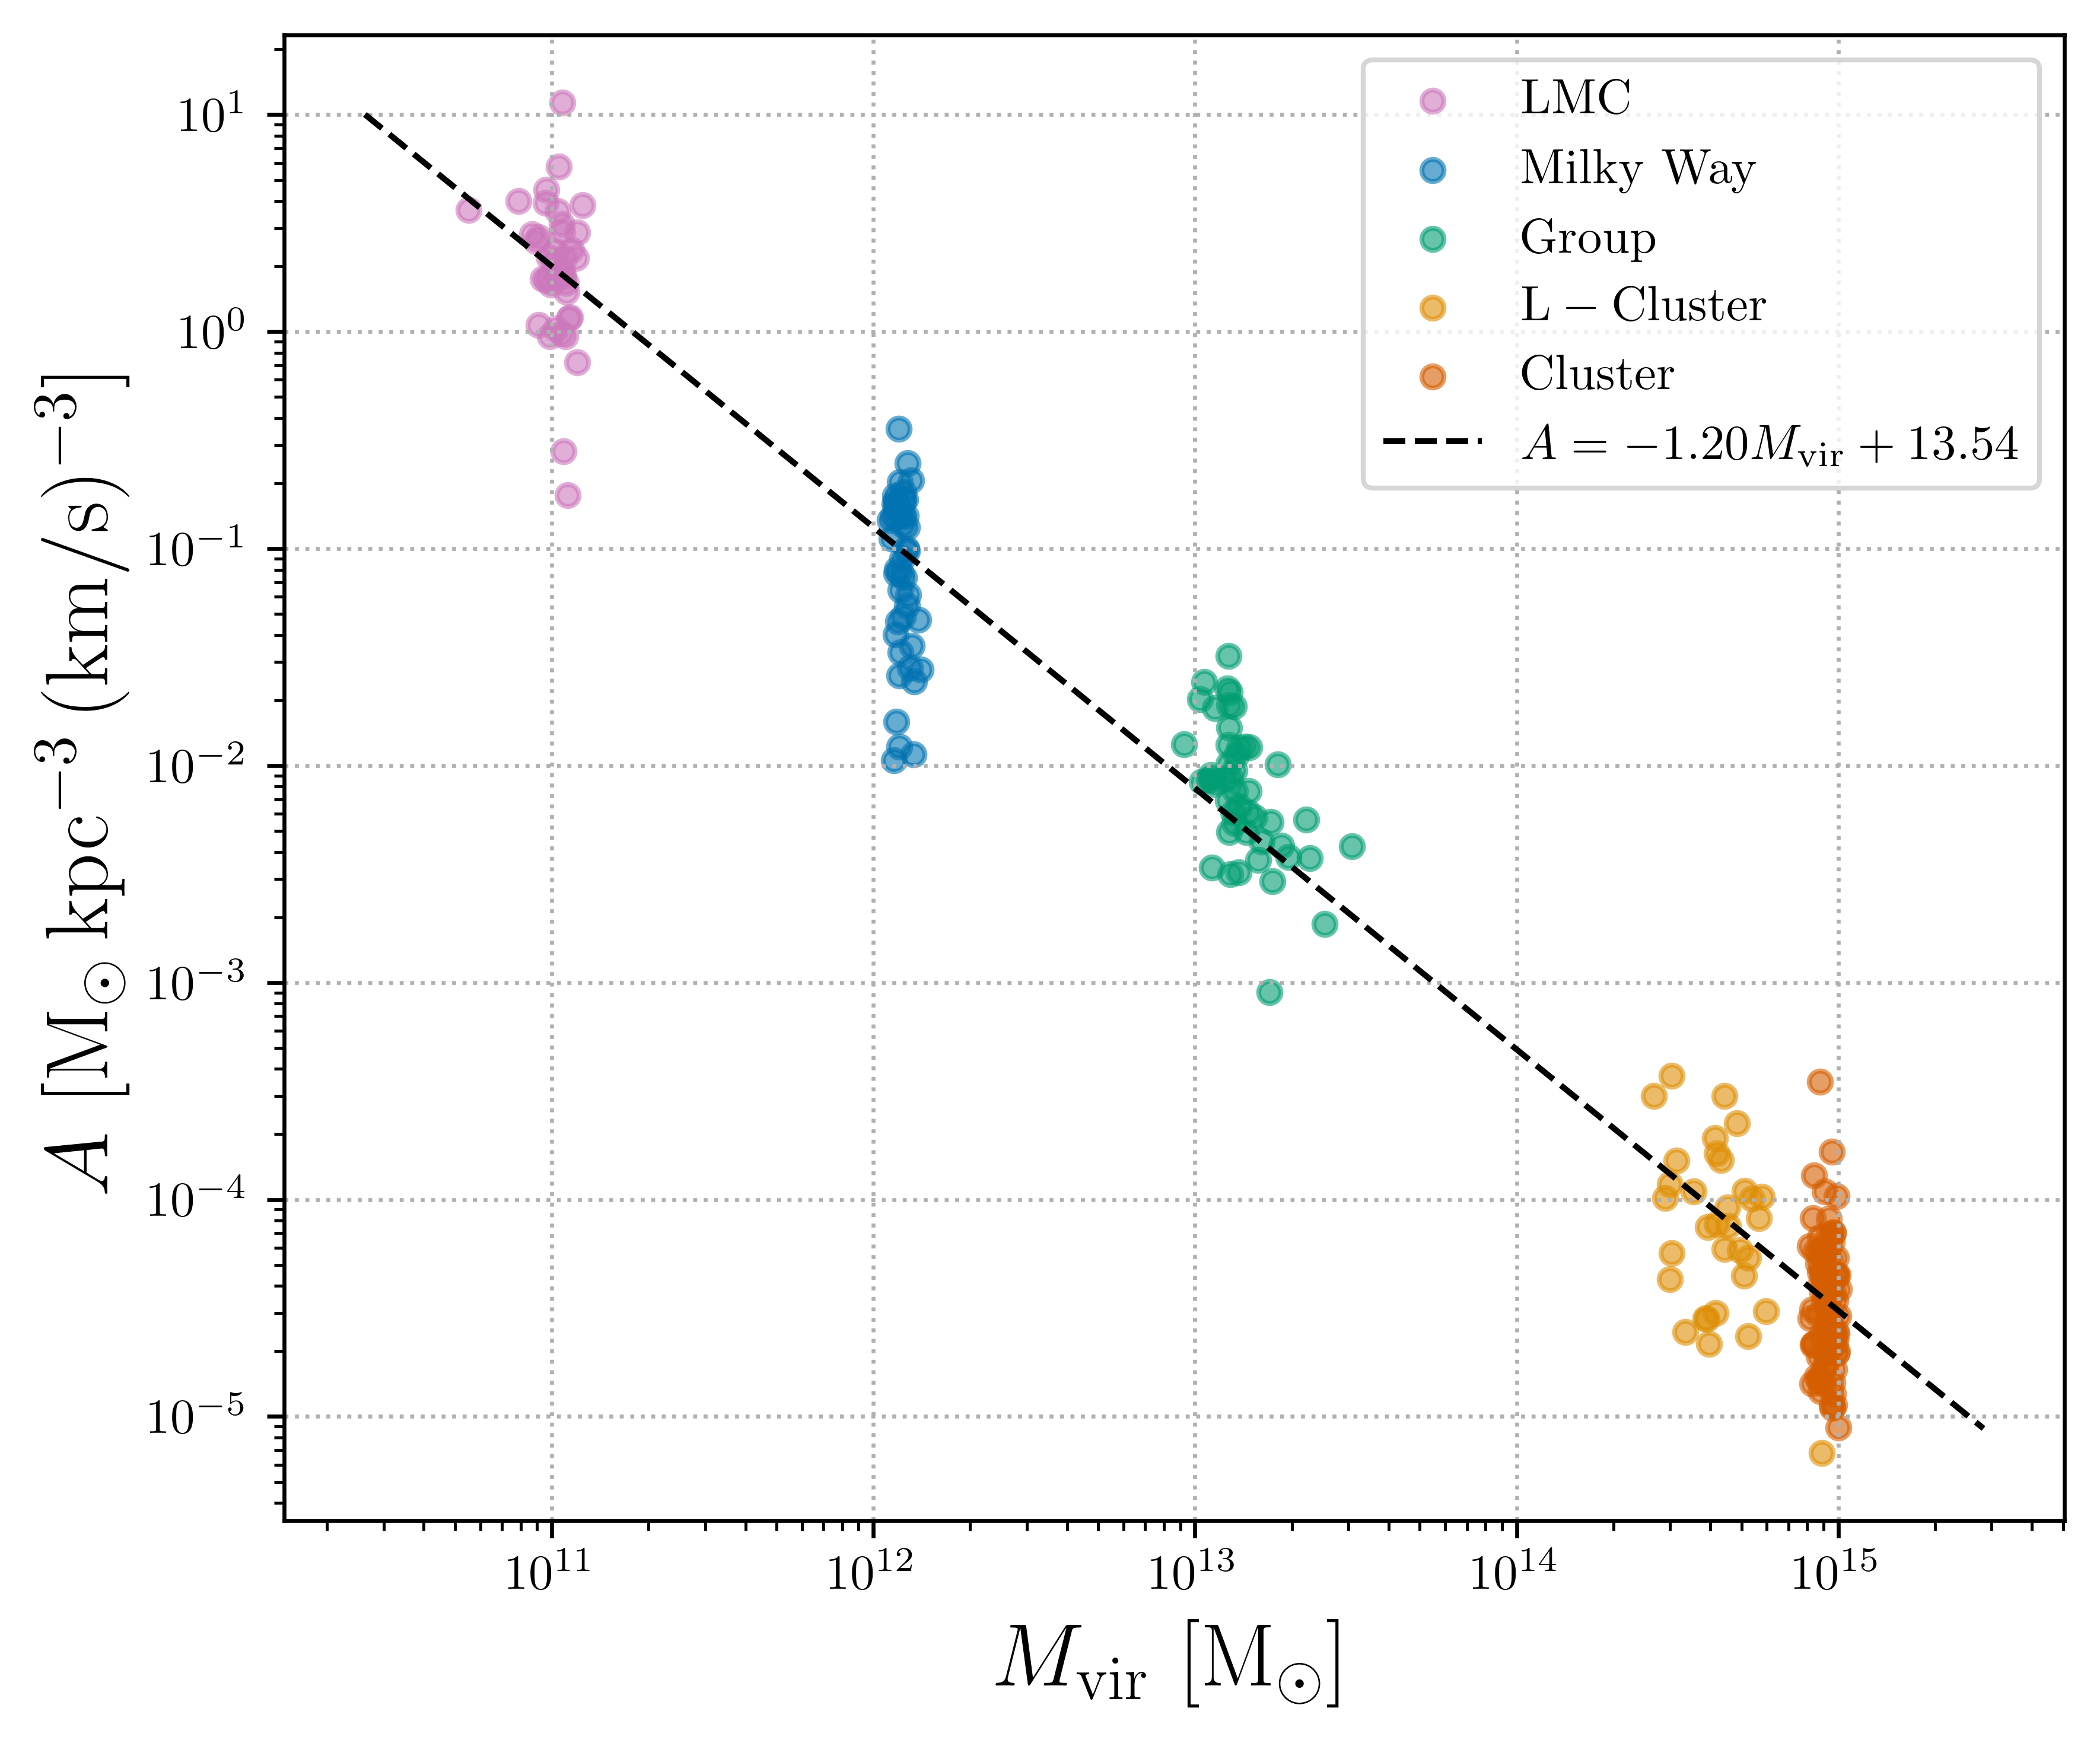

Spearman ρ (all halos) = -0.930  (p = 2.017e-107)
SymphonyLMC       :  ρ = -0.283,   p = 8.086e-02
SymphonyMilkyWay  :  ρ = -0.189,   p = 2.139e-01
SymphonyGroup     :  ρ = -0.574,   p = 1.585e-05
SymphonyLCluster  :  ρ = -0.196,   p = 2.738e-01
SymphonyCluster   :  ρ = -0.086,   p = 4.559e-01


<Figure size 640x480 with 0 Axes>

In [ ]:
def fit_powerlaw(x, y, min_pts=5):
    """Return (A, alpha) for y = A x^{-alpha} in log–log space."""
    mask = np.isfinite(x) & np.isfinite(y) & (x > 0) & (y > 0)
    if mask.sum() < min_pts:
        return np.nan, np.nan
    logx, logy = np.log10(x[mask]), np.log10(y[mask])
    slope, intercept = np.polyfit(logx, logy, 1)
    alpha = -slope
    A = 10 ** intercept
    return A, alpha


def gather_normalizations(base_dir):
    records = []
    for suite in suite_names:
        in_dir = os.path.join(base_dir, "data", suite, "ppsd_profiles")
        files = sorted(f for f in os.listdir(in_dir) if f.endswith(".csv"))
        rvir_df = pd.read_csv(os.path.join(base_dir, "data", suite, "virial_radius.csv"),
                              dtype={"halo_id": str})
        vvir_df = pd.read_csv(os.path.join(base_dir, "data", suite, "virial_velocity.csv"),
                              dtype={"halo_id": str})
        mvir_df = pd.read_csv(os.path.join(base_dir, "data", suite, "halo_mass.csv"),
                              dtype={"halo_id": str})
        rvmax_df = pd.read_csv(os.path.join(base_dir, "data", suite, "max_radius.csv"),
                               dtype={"halo_id": str})
        params = symlib.simulation_parameters(suite)
        H0_si = params["H0"] * u.km / u.s / u.Mpc
        G_si = G.to(u.Mpc**3 / u.Msun / u.s**2)
        rho_crit = (3 * H0_si**2 / (8 * np.pi * G_si)).to(u.Msun / u.kpc**3).value
        rho_m = params["Om0"] * rho_crit

        for f in files:
            halo_id = f.split("_")[1]
            prof = pd.read_csv(os.path.join(in_dir, f))
            r_scaled = prof["r_scaled"].values
            Q_rls = prof["Q_r"].values

            if (
                halo_id not in rvir_df["halo_id"].values or
                halo_id not in vvir_df["halo_id"].values or
                halo_id not in rvmax_df["halo_id"].values
            ):
                print(f"[Skip] halo_id {halo_id} missing in one of the meta tables")
                continue

            Rvir = float(rvir_df.loc[rvir_df.halo_id == halo_id, "rvir"].values[0])
            Vvir = float(vvir_df.loc[vvir_df.halo_id == halo_id, "vvir"].values[0])
            Mvir = float(mvir_df.loc[mvir_df.halo_id == halo_id, "mvir"].values[0])
            Rvmax = float(rvmax_df.loc[rvmax_df.halo_id == halo_id, "rvmax"].values[0])

            r_norm = (r_scaled * Rvir) / Rvmax
            Q_dim = Q_rls * rho_m / Vvir ** 3
            A, alpha = fit_powerlaw(r_norm, Q_dim)
            records.append({"suite": suite, "halo_id": halo_id,
                            "A": A, "alpha": alpha, "Mvir": Mvir})
    return pd.DataFrame(records)


def plot_A_vs_mass(df):
    fig, ax = plt.subplots(figsize=(6, 5), dpi=600)
    plt.rcParams['text.usetex'] = True

    for suite in suite_names:
        sub = df[df["suite"] == suite]
        ax.scatter(sub["Mvir"], sub["A"], s=20,
                   color=sim_colors[suite], label = rf"$\mathrm{{{sim_names[suite]}}}$", alpha=0.6)

    # global best-fit line in log–log space
    finite = df[["A", "Mvir"]].dropna()
    logM, logA = np.log10(finite["Mvir"].values), np.log10(finite["A"].values)
    slope, intercept = np.polyfit(logM, logA, 1)
    x_line = np.logspace(logM.min() * 0.97, logM.max() * 1.03, 200)
    ax.plot(x_line, 10 ** (intercept + slope * np.log10(x_line)),
            "k--", lw=1.2, label=rf"$A={slope:.2f}M_{{\mathrm{{vir}}}}+{intercept:.2f}$")

    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(r"$M_{\mathrm{vir}}\ [{\rm M_\odot}]$", fontsize=18)
    ax.set_ylabel(r"$A\ [{\rm M_\odot\,kpc^{-3}\,(km/s)^{-3}}]$", fontsize=18)
    ax.grid(True, which="major", ls=":")
    ax.legend(fontsize=10, frameon=True)
    fig.tight_layout()
    plt.show()
    plt.savefig(os.path.join(base_dir,'figure', f"ppsd_norm_mass_relation.pdf"))

    plt.close(fig)

def norm_mass_relation():
    df = gather_normalizations()
    plot_A_vs_mass(df)
    valid = df[["A", "Mvir"]].dropna()
    rho, pval = spearmanr(np.log10(valid["A"]), np.log10(valid["Mvir"]))
    print(f"Spearman ρ (all halos) = {rho:.3f}  (p = {pval:.3e})")
    for suite in suite_names:
        sub = df[df["suite"] == suite][["A", "Mvir"]].dropna()
        if len(sub) < 3:
            print(f"{suite}: insufficient halos for Spearman test")
            continue
        rho_s, pval_s = spearmanr(np.log10(sub["A"]), np.log10(sub["Mvir"]))
        print(f"{suite:18s}:  ρ = {rho_s:.3f},   p = {pval_s:.3e}")

norm_mass_relation(base_dir)
